# Get SMILES of molecules with atoms with degree=6

1. 3 molecules have **S** atom with GetDegree (number of neighbours in graph) parameter = $6$ (SMILES-logP):

    FS(F)(F)(F)(F)c1ccccc1 - $3.36$
    
    FS(F)(F)(F)(F)F - $1.68$
    
    O=C(O)COc1cccc(S(F)(F)(F)(F)F)c1 - $2.78$
    
2. There are **B**, **Ca**, **Fe** atomtypes that are presented only once and **K** - $5$ times

3. Overall after **H** and **C** most common atomtypes are **O**, **N**, **Cl**, **S**, **F**, **Br**, **P**, **I**, **Na**

    ![](https://sun9-18.userapi.com/c206728/v206728518/15b119/Pe8-HGcwcnE.jpg)

In [17]:
import pandas as pd
import os
from rdkit.Chem import MolFromSmiles
import numpy as np
DATASET_PATH = '../../../data/3_final_data'

logP_dataset = pd.read_csv(os.path.join(DATASET_PATH,'logp_mean.csv'), index_col = 0)

SMILES_COLUMN = 'smiles'

In [7]:
def get_bad_molecules(data_path = '../../../data/raw/', prefix_name = 'broken_smiles'):
    import os
    broken_smiles = []
    for entry in  os.listdir(data_path):
        if os.path.isfile(os.path.join(data_path, entry)) and prefix_name in entry:
            broken_smiles+=list(map(lambda x: x.rstrip(),open(os.path.join(data_path,entry),'r').readlines()))
    

    return list(set(broken_smiles))

In [8]:
bad_SMILES = get_bad_molecules()

In [9]:
logP_dataset[logP_dataset[SMILES_COLUMN].isin(bad_SMILES)]

,smiles,logP
9897,FS(F)(F)(F)(F)c1ccccc1,3.36
11745,O=C(O)COc1cccc(S(F)(F)(F)(F)F)c1,2.78


In [12]:
for SMILES in bad_SMILES:
    print(SMILES)
    mol = MolFromSmiles(SMILES)
    for atom in mol.GetAtoms():
        if atom.GetDegree() not in range(6):
            print (atom.GetSymbol(), atom.GetDegree())

O=C(O)COc1cccc(S(F)(F)(F)(F)F)c1
('S', 6)
FS(F)(F)(F)(F)c1ccccc1
('S', 6)


In [13]:
def create_element_dict(data, amount=20, add_H=True, SMILES_COLUMN='smiles'):
    from rdkit import Chem
    """Define what chemical elements are used in molecules
        Parameters
        ----------
        data
            pandas.DataFrame containing smiles of molecules in dataset
        amount
            Number of types of atoms to store
        add_H
            True or False: store info of H atoms or not        
        Returns
        -------
        elements
            dictionary with {atom name : number} mapping
        """
    elements={}
    norm=0
    for smile in data[SMILES_COLUMN]:
        molecule=Chem.MolFromSmiles(smile)
        molecule=Chem.AddHs(molecule)

        for i in range(molecule.GetNumAtoms()):
            atom = molecule.GetAtomWithIdx(i)
            element=atom.GetSymbol()
            norm+=1
            if element in elements.keys():
                elements[element]+=1
            else:
                elements[element]=1
    print(elements)
    if not add_H:
        del elements['H']
    norm = max(elements.values())
    for key in elements.keys():
        elements[key]/=float(norm)
    from collections import OrderedDict
    dd = OrderedDict(sorted(elements.items(), key=lambda x: x[1]))
    elements=list(dd.keys())[-amount:]  
    return dd 

In [14]:
elements = create_element_dict(logP_dataset, amount=20, add_H=True, SMILES_COLUMN=SMILES_COLUMN)

{'C': 171219, 'B': 1, 'Cl': 4585, 'I': 259, 'H': 203763, 'Ca': 1, 'F': 2590, 'O': 33622, 'N': 24872, 'P': 333, 'S': 3598, 'Fe': 1, 'Br': 624, 'Na': 68, 'K': 5}


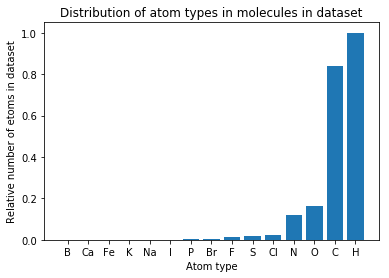

In [18]:
import matplotlib.pyplot as plt

plt.bar(*zip(*elements.items()))
plt.title('Distribution of atom types in molecules in dataset')
plt.ylabel('Relative number of etoms in dataset')
plt.xlabel('Atom type')
plt.show()

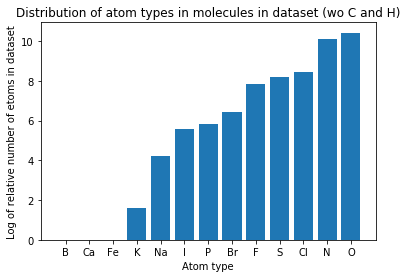

In [19]:
edited_elements = elements.copy()

del edited_elements['H']
del edited_elements['C']

norm = float(min(edited_elements.values()))
for key in edited_elements.keys():
    edited_elements[key]=np.log(edited_elements[key]/norm)

plt.bar(*zip(*edited_elements.items()))
plt.title('Distribution of atom types in molecules in dataset (wo C and H)')
plt.ylabel('Log of relative number of etoms in dataset')
plt.xlabel('Atom type')
plt.show()